<h1><center>Segment customers of an e-commerce: Modeling</center></h1>

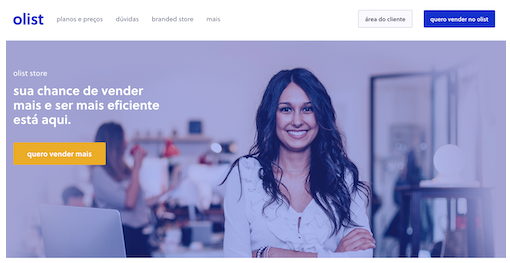

### TABLE OF CONTENTS
#### Project display
#### 1. Preprocessing and Modeling
* 1-1. Importing Python Libraries and dependencies
* 1-2. Get the Data
* 1-3. Computing and visualizing RFM variables.

#### 2. Modeling
* 2.1 Finding the optimal Number of Clusters.
* * 2.1.1 Clusters number vs Inertia
* * 2.1.2 Clusters number vs Distortion
* * 2.1.3 Clusters number vs Silhouette Score
* 2.2 KMeans Clustering
* 2.3 Implementing DBSCAN

#### 3. Conclusion


### Project display

**Olist** wants to provide its e-commerce teams with **customer segmentation** that they can use on a daily basis for their communication campaigns.

The goal is to understand the different types of users through their behavior and personal data.

The goal is to provide the marketing team with an actionable description of a segmentation and its underlying logic for optimal use, as well as a maintenance contract proposal based on an analysis of segment stability over the course of the time.

### 1.  Preprocessing and Modeling
#### 1-1. Importing Python Libraries and dependencies 

In [1]:
from olist_eda_functions import *
from olist_modeling_functions import *

%pylab inline
%matplotlib inline
pd.set_option('display.max_columns',200)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# For full display of DataFrames.
pd.set_option("expand_frame_repr", True)

#### 1-2. Get the Data

In [3]:
# Load pickle from disk
df_rfm = pd.read_pickle('pickle_df_rfm.pkl')
df = pd.read_pickle('pickle_df.pkl')
#df = pd.read_pickle('pickle-file.pkl.gz', compression='gzip')

In [4]:
df_rfm.head()

,Recency,Frequency,Monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19
0000f46a3911fa3c0805444483337064,536,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62
0004aac84e0df4da2b147fca70cf8255,287,1,196.89


In [5]:
# check if the data types are well preserved
df_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91151 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    91151 non-null  int64  
 1   Frequency  91151 non-null  int64  
 2   Monetary   91151 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.8+ MB


#### 1.3 Computing and visualizing RFM variables.

K-means clustering algorithm is an unsupervised machine learning algorithm that uses multiple iterations to segment the unlabeled data points into ‘k's different clusters in a way such that each data point belongs to only a single group that has similar properties. These points are more similar between them than they are to points belonging to other clusters. Distance-based clustering groups the points into some number of clusters such that distances within the cluster should be small while distances between clusters should be large.

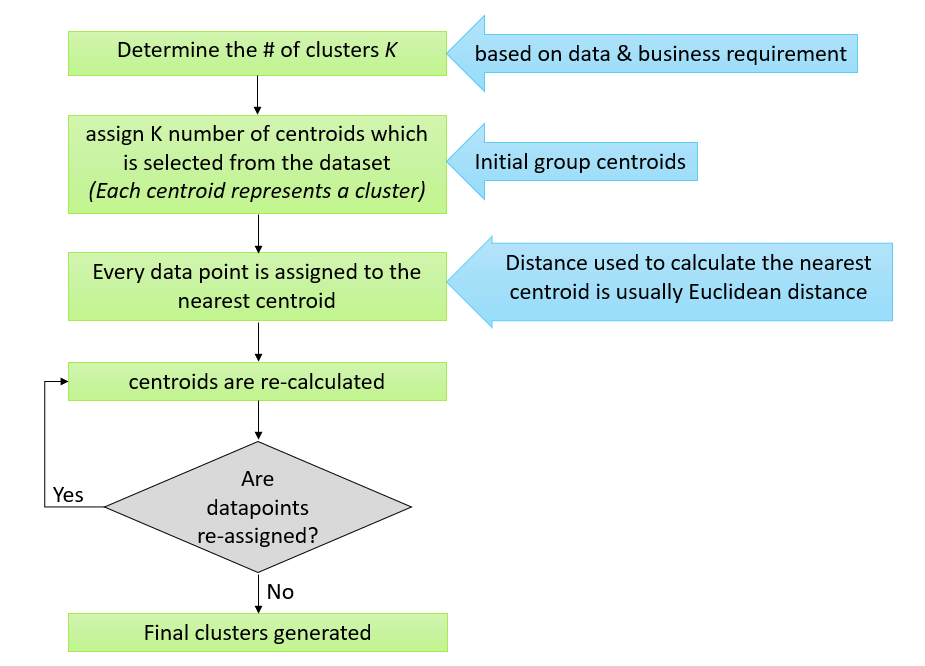

K-means uses Euclidean distance as a distance metric to calculate the distance between each point and the centroid.

**K-means gives the best result under the following conditions:**

    - Data’s distribution is not skewed.
    - Data is standardised (i.e. mean of 0 and standard deviation of 1).
     
Let’s find the **skewness** in our data

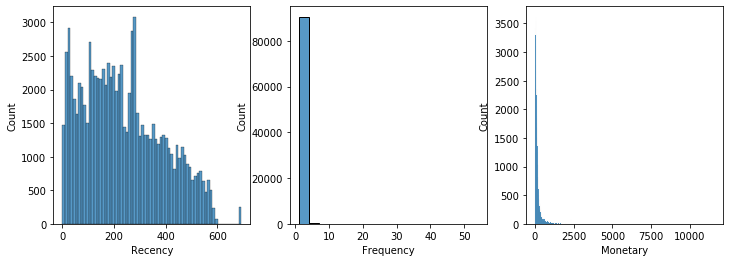

Wall time: 3.6 s


In [6]:
%%time
fig, ax = plt.subplots(1,3, figsize=(12,4))
for i, col in enumerate(df_rfm.columns):
    sns.histplot(df_rfm[col], ax=ax[i])
plt.show()

Perform transformation and check the transformed feature skewness. It is apparent that the features are no longer skewed.

In [7]:
skew_columns = (df_rfm.skew().sort_values(ascending=False))

skew_columns = skew_columns.loc[skew_columns > 0.75]
skew_columns

Frequency    20.384310
Monetary      7.902465
dtype: float64

#### Log Transformation

The data is highly skewed, therefore we will perform log transformations to reduce the skewness of each variable. I added a small constant as log transformation demands all the values to be positive.

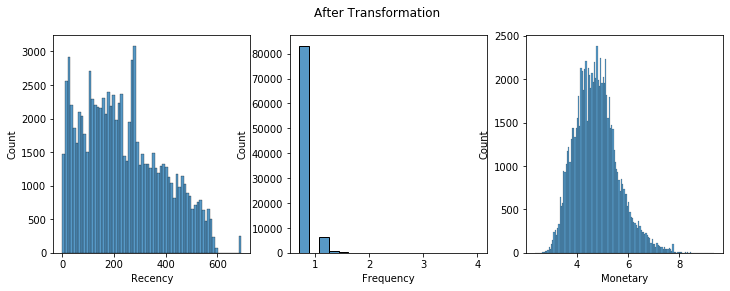

Wall time: 926 ms


In [8]:
%%time
df_rfm_log = df_rfm.copy()
for col in skew_columns.index.tolist():
    df_rfm_log[col] = np.log1p(df_rfm_log[col])


fig, ax = plt.subplots(1,3, figsize=(12,4))
for i, col in enumerate(df_rfm_log.columns):
    sns.histplot(df_rfm_log[col], ax=ax[i])
plt.suptitle('After Transformation')
plt.show()

In [9]:
(df_rfm_log.skew().sort_values(ascending=False))

Frequency    4.670825
Monetary     0.568783
Recency      0.446155
dtype: float64

Once the skewness is reduced, we standardised the data by centring and scaling. Note all the variables now have mean ±0 and standard deviation ±1.

In [10]:
# Standarisation
scaler = StandardScaler()
scaler.fit(df_rfm_log)
rfm_scaled = scaler.transform(df_rfm_log)

In [11]:
df_rfm_scaled = pd.DataFrame(rfm_scaled, index=df_rfm.index, columns=df_rfm.columns)
df_rfm_scaled.head()

,Recency,Frequency,Monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,-0.821842,-0.28106,0.249489
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.802195,-0.28106,-1.688862
0000f46a3911fa3c0805444483337064,1.961498,-0.28106,-0.340087
0000f6ccb0745a6a4b88665a16c9f078,0.546907,-0.28106,-1.140481
0004aac84e0df4da2b147fca70cf8255,0.330788,-0.28106,0.638270


In [12]:
df_rfm_scaled.describe().round(4)

,Recency,Frequency,Monetary
count,91151.0000,91151.0000,91151.0000
mean,0.0000,-0.0000,-0.0000
std,1.0000,1.0000,1.0000
min,-1.5488,-0.2811,-2.8580
25%,-0.8087,-0.2811,-0.7079
50%,-0.1211,-0.2811,-0.0650
75%,0.7106,-0.2811,0.5855
max,2.9962,21.4200,5.4977


### 2. Modeling

Perform KMeans clustering with different number of clusters to search for the optimal clusters number. We will choose the number of clusters by:

1. Elbow method: Compare the inertia or the distortion the clusters number and choose the configuration that leads to lowest inertia or distortion. We will choose the clusters number k that after which point the distortion and inertia decreases only slowly compared to before, hence the 'elbow'.


2. Silhouette analysis Silhouette score ranges from -1 to +1 and indicates the separation distance of the clusters. A score of +1 means the sample is located far away from the neighboring cluster. A score of 0 means the sample is on the decision boundary. A score of -1 means the sample is clustered wrongly.

#### 2.1 Finding the optimal Number of Clusters.

A different number of clusters can lead us to completely different results. Therefore, it’s important to get the optimal number of clusters for our analysis. To find it out, we will apply Elbow Method. Elbow Method simply tells the optimal cluster number for optimal inertia.

For each value of K, we are calculating WCSS ( Within-Cluster Sum of Square ). WCSS is the sum of squared distance between each point and the centroid in a cluster. When we plot the WCSS with the K value, the plot looks like an Elbow. As the number of clusters increases, the WCSS value will start to decrease.

#### 2.1.1 Clusters number vs Inertia

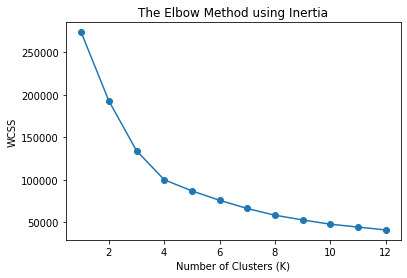

Wall time: 1min 3s


In [13]:
%%time
wcss=[] # Within-Cluster Sum of Square
for i in range(1,13):
    kmeans=KMeans(n_clusters=i, init='k-means++',random_state=0)
    kmeans.fit(df_rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,13), wcss, marker='o',ls='-')
plt.title('The Elbow Method using Inertia')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.show()

#### 2.1.2 Clusters number vs Distortion

It is hard to decide the optimal clusters number since there is no clear cut-off ('elbow') from the graph below.

Wall time: 1min 2s


[Text(0, 0.5, 'Distortion'), Text(0.5, 0, 'Number of Clusters (K)')]

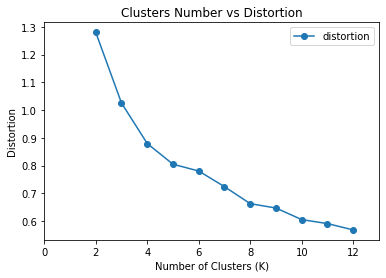

In [14]:
%%time
km_list = []

for clust in range(2,13):
    km = KMeans(n_clusters=clust, random_state=26)
    km = km.fit(df_rfm_scaled)
    
    km_list.append(pd.Series({'clusters': clust, 
                              'distortion': sum(np.min(cdist(df_rfm_scaled, km.cluster_centers_,
                                        'euclidean'), axis=1)) / df_rfm_scaled.shape[0],
                              'model': km}))

plot_data = (pd.concat(km_list, axis=1)
             .T
             [['clusters','distortion']]
             .set_index('clusters'))

ax = plot_data.plot(marker='o',ls='-')
ax.set_xticks(range(0,13,2))
ax.set_xlim(0,13)
ax.set_title('Clusters Number vs Distortion')
ax.set(xlabel='Number of Clusters (K)', ylabel='Distortion');

#### 2.1.3 Clusters number vs Silhouette Score

The optimal clusters number k is around 3 or 4, we simulate clusters number of k−1, k, and k+1 (from 2 to 6).We will plot the silhouette score of each cluster for different clusters number. The higher the score means the samples are more separated from the neighboring clusters. From the graphs below, the higher the clusters number, the smaller the silhouette score. 

For n_clusters = 2 The average silhouette_score is : 0.5411782488856729
For n_clusters = 3 The average silhouette_score is : 0.35394009950741623
For n_clusters = 4 The average silhouette_score is : 0.355413204853079
For n_clusters = 5 The average silhouette_score is : 0.33272260527841424


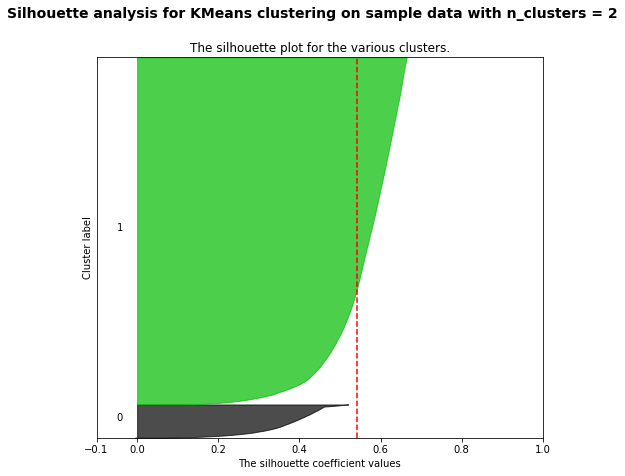

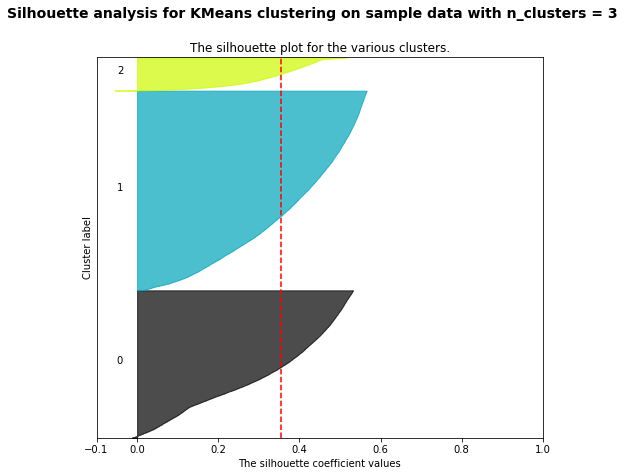

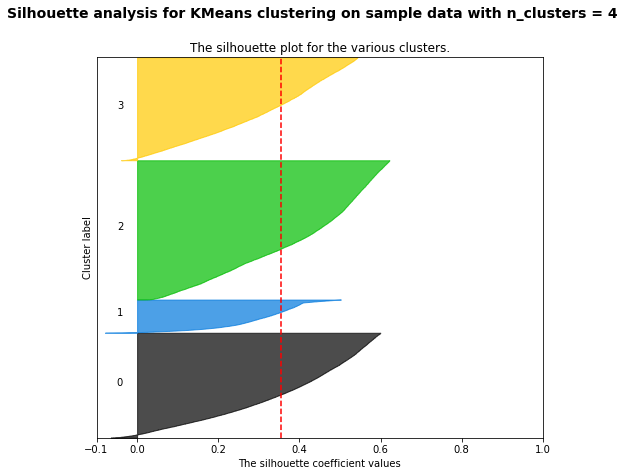

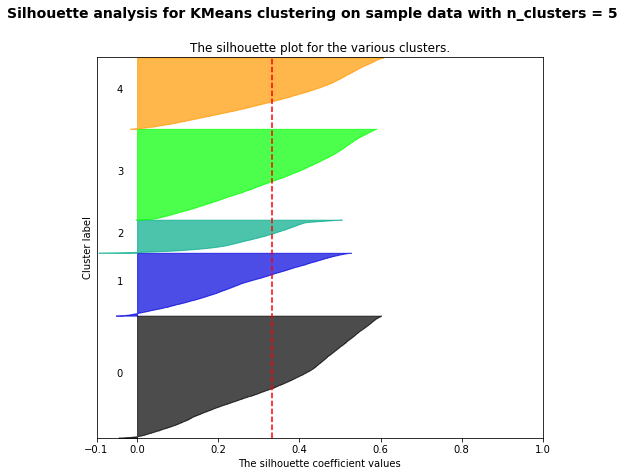

Wall time: 22min


In [15]:
%%time
plot_silhouette_analysis(df_rfm_scaled, 2, 6)
plt.show()

The vertical dashed lines represent the silhouette score for each number of clusters. When most of the instances in a cluster have a lower coefficient than this score (i.e., if many of the instances stop short of the dashed line, ending to the left of it), then the cluster is rather bad since this means its instances are much too close to other clusters. We can see that when k=2, we get bad clusters. But when k=3, k=4 the clusters look pretty good – most instances extend beyond the dashed line, to the right. When k=3, the cluster at index 1, is rather big, while when k=4, all clusters have almost similar sizes, so even though the overall silhouette score from k=3 is slightly greater than for k=4, it seems like a good idea to use k=4 to get clusters of similar sizes.

#### 2.2 KMeans Clustering

#### Clusters Number = 2

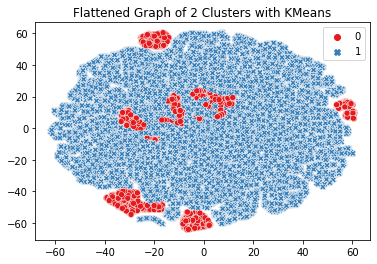

Wall time: 15min 14s


In [16]:
%%time
df_km_2, labels_2 = k_means(df_rfm_scaled, 2)
df_label_2 = df_rfm.assign(Cluster = labels_2)
plt.title('Flattened Graph of 2 Clusters with KMeans')
plt.show()

#### Clusters Number = 3

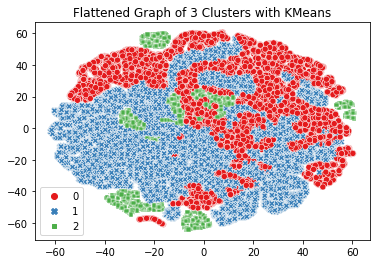

Wall time: 15min 4s


In [17]:
%%time
df_km_3, labels_3 = k_means(df_rfm_scaled, 3)
df_label_3 = df_rfm.assign(Cluster = labels_3)
plt.title('Flattened Graph of 3 Clusters with KMeans')
plt.show()

#### Clusters Number = 4

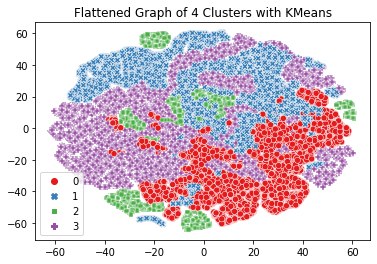

Wall time: 15min 12s


In [18]:
%%time
df_km_4, labels_4 = k_means(df_rfm_scaled, 4)
df_label_4 = df_rfm.assign(Cluster = labels_4)
plt.title('Flattened Graph of 4 Clusters with KMeans')
plt.show()

#### Clusters Number = 5

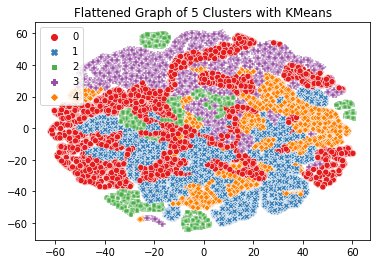

Wall time: 15min 2s


In [19]:
%%time
df_km_5, labels_5 = k_means(df_rfm_scaled, 5)
df_label_5 = df_rfm.assign(Cluster = labels_5)
plt.title('Flattened Graph of 5 Clusters with KMeans')
plt.show()

#### Customer Segmentation Result

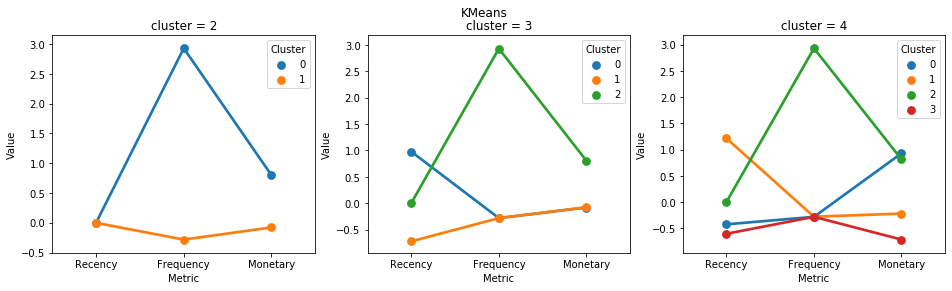

Wall time: 9.76 s


In [20]:
%%time
fig, ax = plt.subplots(1,3, figsize=(16,4))
plt.subplot(1,3,1)
ax[0]=snake_plot(df_rfm_scaled, df_km_2, df_rfm)
ax[0].set_title('cluster = 2')
plt.subplot(1,3,2)
ax[1]=snake_plot(df_rfm_scaled, df_km_3, df_rfm)
ax[1].set_title('cluster = 3')
plt.subplot(1,3,3)
ax[2]=snake_plot(df_rfm_scaled, df_km_4, df_rfm)
ax[2].set_title('cluster = 4')

plt.suptitle('KMeans')
plt.show()

#### Customer Segmentation Result

We made a snake plot for the cluster against the value for Recency, Frequency, and Monetary to see how the cluster differs from each other.

We can differentiate the Recency, Frequency, and Monetary values into (roughly) low, med, and high level for all clusters number. 

In [21]:
df_clusters = rfm_values(df_label_4)
df_clusters.head()

Recency           Frequency         Monetary                       
           mean  min  max      mean min max     mean    min      max  count
Cluster                                                                    
0         172.0    0  579       1.0   1   1    315.0  119.0   2316.0  24640
1         422.0  263  694       1.0   1   2    118.0   12.0   1424.0  25174
2         237.0    0  694       2.0   2  54    360.0   16.0  11579.0   7948
3         144.0    0  360       1.0   1   2     69.0   10.0    139.0  33389

#### 2.3 Implementing DBSCAN

First, we need to estimate and specify parameters for DBSCAN, start by minPts and follow by eps using the former. If minPts=1, every data point will form a cluster by itself, means if we have n data, we gonna have n clusters. This does not make any sense for clustering to be done. If minPts=2, it will be same as single-linked hierarchy clustering. Hence, minPts should be set as minPts ≥ D+1. Nevertheless, by rule of thumb, it is set to be minPts=2*D below for simplicity. Moving forward, eps is determined from k distance graph. Mean distance from k nearest neighbors is computed and plotted against range from 1:n. The y value of point where 'elbow' is spotted on the curve, eps=0.1 for this case.

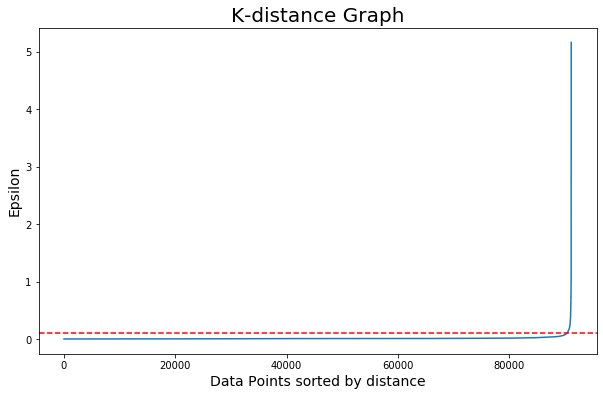

In [22]:
minPts=2*3
nn = NearestNeighbors(n_neighbors=minPts)
nbrs = nn.fit(df_rfm_scaled.iloc[:,:3])
distances, indices = nbrs.kneighbors(df_rfm_scaled.iloc[:,:3])

# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(10,6))
plt.plot(distances)
plt.axhline(y=0.1, color='r', linestyle='--' )
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [23]:
%%time
# fitting DBscan to data using parameter estimated from k distance plot
db=DBSCAN(eps=0.15, min_samples=minPts)
db.fit(df_rfm_scaled.iloc[:,:3])
df_rfm_scaled['db_Cluster']=db.labels_
df_rfm_scaled['db_Cluster'].unique()

Wall time: 13.8 s


array([ 0,  1,  2, -1,  3,  4, 12,  5, 23,  6,  7,  8, 26, 20,  9, 16, 10,
       13, 11, 22, 14, 21, 15, 19, 25, 17, 18, 28, 27, 24], dtype=int64)

In [24]:
df_rfm_scaled['db_Cluster'].value_counts()

 0     82905
 1      6330
-1      1150
 3       336
 2       211
 5        18
 8        11
 14       11
 11       11
 13       11
 9        10
 16       10
 12       10
 21        9
 10        9
 22        9
 25        9
 20        9
 19        8
 7         8
 6         8
 18        7
 26        7
 15        7
 24        7
 4         6
 17        6
 23        6
 28        6
 27        6
Name: db_Cluster, dtype: int64

Getting 28 clusters with DBSCAN, shows that this model does not work in this situation, indeed, it is not a surprise, because it is a model that has some limits: if the density varies significantly across the clusters, it can be impossible for it to capture all the clusters properly. 

The following figure shows how this algorithm did not work.

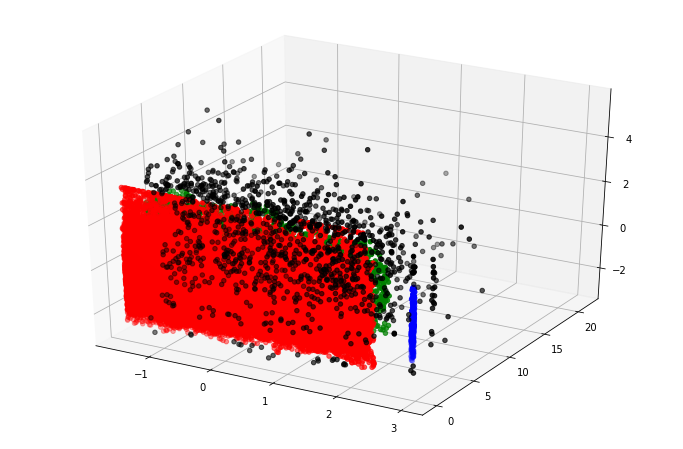

In [25]:
# Plotting the resulting clusters
db0 = df_rfm_scaled[df_rfm_scaled['db_Cluster']==0]
db1 = df_rfm_scaled[df_rfm_scaled['db_Cluster']==1]
db2 = df_rfm_scaled[df_rfm_scaled['db_Cluster']==2]
out = df_rfm_scaled[df_rfm_scaled['db_Cluster']==-1]

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(db0.iloc[:,0], db0.iloc[:,1], db0.iloc[:,2], color='red')
ax.scatter(db1.iloc[:,0], db1.iloc[:,1], db1.iloc[:,2], color='green')
ax.scatter(db2.iloc[:,0], db2.iloc[:,1], db2.iloc[:,2], color='blue')
ax.scatter(out.iloc[:,0], out.iloc[:,1], out.iloc[:,2], color='black')

### 3. RFM with Review Score

In [26]:
# Load pickle from disk
df_rfm_review_score = pd.read_pickle('pickle_df_rfm_review_score.pkl')

In [27]:
df_rfm_review_score.head()

,Recency,Frequency,Monetary,mean_review_score
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,4.0
0000f46a3911fa3c0805444483337064,536,1,86.22,3.0
0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62,4.0
0004aac84e0df4da2b147fca70cf8255,287,1,196.89,5.0


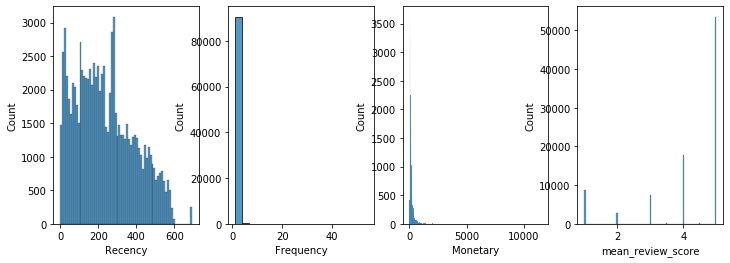

Wall time: 4.27 s


In [28]:
%%time
fig, ax = plt.subplots(1,4, figsize=(12,4))
for i, col in enumerate(df_rfm_review_score.columns):
    sns.histplot(df_rfm_review_score[col], ax=ax[i])
plt.show()

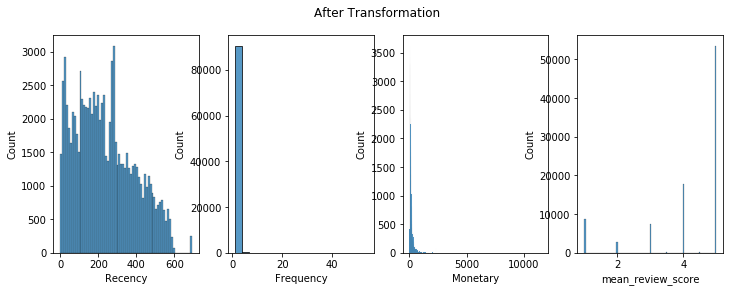

Wall time: 4.02 s


In [29]:
%%time
df_rfm_review_score_log = df_rfm_review_score.copy()
for col in skew_columns.index.tolist():
    df_rfm_log[col] = np.log1p(df_rfm_review_score_log[col])


fig, ax = plt.subplots(1,4, figsize=(12,4))
for i, col in enumerate(df_rfm_review_score_log.columns):
    sns.histplot(df_rfm_review_score_log[col], ax=ax[i])
plt.suptitle('After Transformation')
plt.show()

In [30]:
# Standarisation
scaler = StandardScaler()
scaler.fit(df_rfm_review_score_log)
rfm_review_scaled = scaler.transform(df_rfm_review_score_log)

In [31]:
df_rfm_review_scaled = pd.DataFrame(rfm_review_scaled, index=df_rfm_review_score.index, columns=df_rfm_review_score.columns)
df_rfm_review_scaled.head()

,Recency,Frequency,Monetary,mean_review_score
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,-0.821842,-0.216984,-0.133111,0.661429
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.802195,-0.216984,-0.599717,-0.119796
0000f46a3911fa3c0805444483337064,1.961498,-0.216984,-0.359601,-0.901020
0000f6ccb0745a6a4b88665a16c9f078,0.546907,-0.216984,-0.532885,-0.119796
0004aac84e0df4da2b147fca70cf8255,0.330788,-0.216984,0.090572,0.661429


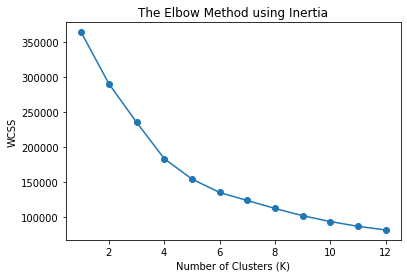

Wall time: 41.5 s


In [32]:
%%time
wcss=[] # Within-Cluster Sum of Square
for i in range(1,13):
    kmeans=KMeans(n_clusters=i, init='k-means++',random_state=0)
    kmeans.fit(df_rfm_review_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,13), wcss, marker='o',ls='-')
plt.title('The Elbow Method using Inertia')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.3957948392418108
For n_clusters = 3 The average silhouette_score is : 0.340877503941593
For n_clusters = 4 The average silhouette_score is : 0.3704384224501549
For n_clusters = 5 The average silhouette_score is : 0.3804756660008018


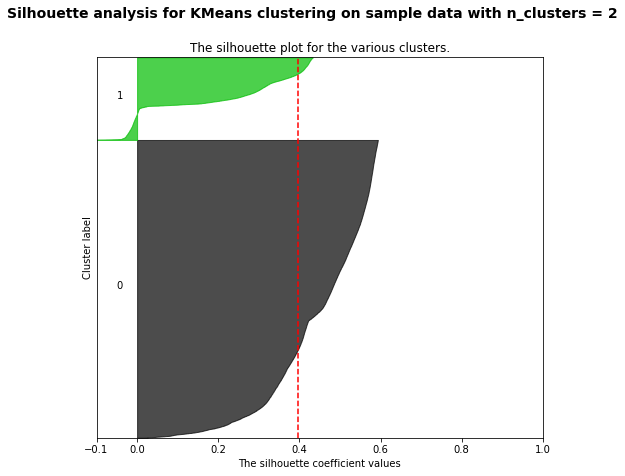

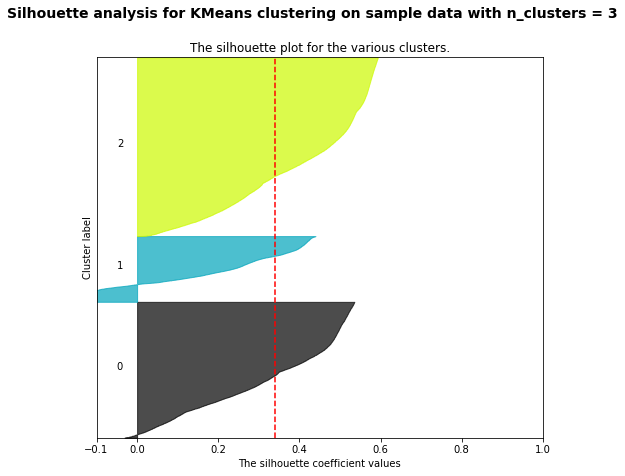

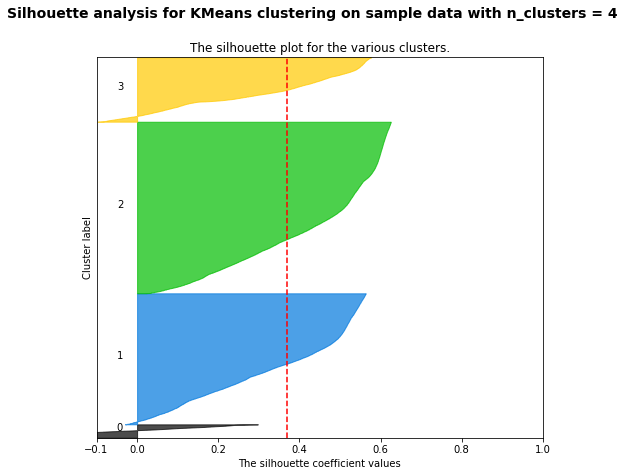

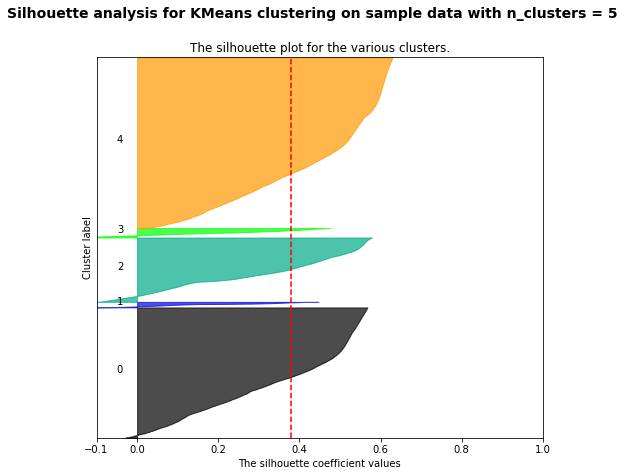

Wall time: 21min 57s


In [33]:
%%time
plot_silhouette_analysis(df_rfm_review_scaled, 2, 6)
plt.show()

**RFM clusters with review score bring bad result: clusters are distributed with negative values, which means these clusters are not good at all.**

### 3. Conclusion

As we know, the machine learning models learn from the data patterns, in this project, the most important features are at 80% constant, in this case, the models can't work properly. 